In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.special import gamma
from scipy.io import loadmat

import math


from RW_NN import IQ_gen_NN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 3024)              12096     
                                                                 
 reshape_1 (Reshape)         (None, 63, 48)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 126, 48)          11568     
 se)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 126, 1)           241       
 nspose)                                                         
                                                                 
 reshape_2 (Reshape)         (None, 126)               0         
                                                                 
Total params: 23,905
Trainable params: 23,905
Non-trai

## Load data

In [12]:
#### Meshgrid ####
n_grid = 100
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z)

# calculate scattering function
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/r_grid[0].shape[0]
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

#################################
S_q_Grid = []
p_Grid = []
for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/grid/S_q_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']

    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/grid/S_q_{}.5.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']

    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

S_q_Grid = np.array(S_q_Grid).reshape(100*len(p_Grid),128)[:,1:-1].astype(np.float32)
p_Grid = np.array(p_Grid).reshape(100*len(p_Grid),3)
S_q_sm_Grid = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Grid)])).astype(np.float32)
log_S_q_Grid = np.log(S_q_Grid)
log_S_q_sm_Grid = np.log(S_q_sm_Grid)

k_z = p_Grid[:,0].astype(np.float32)
alpha = p_Grid[:,1].astype(np.float32)
kappa = p_Grid[:,2].astype(np.float32)
logkappa = np.log(kappa).astype(np.float32)
set_k_z = np.unique(k_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique(kappa))

print('\nk_z in')
print(set_k_z)
print('\nalpha in')
print(set_alpha)
print('\nkappa in')
print(set_kappa)

#################################
S_q_Rand = []
p_Rand = []
for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/rand/S_q_rand_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']

    S_q_Rand.append(S_q_kxy)
    p_Rand.append(k_grid)

S_q_Rand = np.array(S_q_Rand).reshape(100*len(p_Rand),128)[:,1:-1]
p_Rand = np.array(p_Rand).reshape(100*len(p_Rand),3)
S_q_sm_Rand = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Rand)]))
log_S_q_Rand = np.log(S_q_Rand)
log_S_q_sm_Rand = np.log(S_q_sm_Rand)

k_z_Rand = p_Rand[:,0].astype(np.float32)
alpha_Rand = p_Rand[:,1].astype(np.float32)
kappa_Rand = p_Rand[:,2].astype(np.float32)
logkappa_Rand = np.log(kappa_Rand)

## kappa>=1
p_Grid = np.array(p_Grid)
index_kappa = kappa>=1

p_Grid = p_Grid[index_kappa,:]
S_q_Grid = S_q_Grid[index_kappa,:]
S_q_sm_Grid = S_q_sm_Grid[index_kappa,:]
k_z = k_z[index_kappa]
kappa = kappa[index_kappa]
alpha = alpha[index_kappa]

set_k_z = np.unique(k_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique(kappa))


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


In [13]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_k_z = np.abs(k_z-parameters[0])<tol
    id_alpha = np.abs(alpha-parameters[2])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

## Plot and fit

In [14]:
# fig = plt.figure(figsize=(12,8))

# # varying k_z
# ax1 = fig.add_subplot(2,3,1)
# ax4 = fig.add_subplot(2,3,4)
# for i, k_z_i in enumerate(set_k_z):
#     parameters = [k_z_i,set_kappa[0],set_alpha[0]]
#     index = id_params(parameters)

#     ## fitting
#     IQ_GT = S_q_sm_Grid[index,]
#     def loss(fp):
#         lmbda = np.sum((np.log(IQ_GT)-np.log(IQ_gen_NN(fp)))**2)
#         return(lmbda)

#     x0 = [5, 128, 0]
#     lb =  [1, 0.125, 0]
#     ub =  [10, 128, 0.5]

#     x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))

#     opti_P = opt.minimize(loss, x0=np.array(x0), bounds = x_bounds,
#                       method='L-BFGS-B',
#                       jac='3-point',
#                       options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
#                       )
#     fp_opt = opti_P.x
#     fp_k_z = fp_opt.copy()

#     print('GT  = [{}, {}, {}]'.format(*parameters))
#     print('fit = [{}, {}, {}]'.format(*fp_k_z))

#     S_q_gen_NN = (IQ_gen_NN(fp_opt))

#     color = plt.cm.viridis(i/10)
#     ax1.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
#     ax1.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

#     ax4.plot(parameters[0]/20,fp_opt[0]/20,'s',color=color)

# ax1.set_xlabel(r'$Q$',fontsize=20)
# ax1.set_ylabel(r'$I(Q)$',fontsize=20)
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax1.set_ylim([1e-9,1e-3])
# ax1.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# ax4.plot([0,0.55],[0,0.55],'-k',zorder=-1)
# ax4.set_xlabel(r'GT',fontsize=20)
# ax4.set_ylabel(r'NN',fontsize=20)
# ax4.set_xlim([0,0.55])
# ax4.set_ylim([0,0.55])
# ax4.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# plt.tight_layout()

# # varying kappa
# ax2 = fig.add_subplot(2,3,2)
# ax5 = fig.add_subplot(2,3,5)
# for i, kappa_i in enumerate(set_kappa):
#     parameters = [set_k_z[0],kappa_i,set_alpha[0]]
#     index = id_params(parameters)

#     ## fitting
#     IQ_GT = S_q_sm_Grid[index,]
#     def loss(fp):
#         lmbda = np.sum((np.log(IQ_GT)-np.log(IQ_gen_NN(fp)))**2)
#         return(lmbda)

#     x0 = [1, 10, 0]
#     lb =  [1, 0.125, 0]
#     ub =  [10, 128, 0.5]

#     x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))

#     opti_P = opt.minimize(loss, x0=np.array(x0), bounds = x_bounds,
#                       method='L-BFGS-B',
#                       jac='3-point',
#                       options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
#                       )
#     fp_opt = opti_P.x
#     fp_kappa = fp_opt.copy()

#     print('GT  = [{}, {}, {}]'.format(*parameters))
#     print('fit = [{}, {}, {}]'.format(*fp_kappa))

#     S_q_gen_NN = (IQ_gen_NN(fp_opt))

#     color = plt.cm.viridis(np.log(kappa_i)/np.log(128)) 
#     ax2.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
#     ax2.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

#     ax5.plot(parameters[1],fp_opt[1],'s',color=color)

# ax2.set_xlabel(r'$Q$',fontsize=20)
# # ax2.set_ylabel(r'$I(Q)$',fontsize=20)
# ax2.set_yscale('log')
# ax2.set_xscale('log')
# ax2.set_ylim([1e-9,1e-3])
# ax2.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# ax5.plot([0.1,160],[0.1,160],'-k',zorder=-1)
# ax5.set_xlabel(r'GT',fontsize=20)
# # ax5.set_ylabel(r'NN',fontsize=20)
# ax5.set_xlim([0.1,160])
# ax5.set_ylim([0.1,160])
# ax5.set_yscale('log')
# ax5.set_xscale('log')
# ax5.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# # varying alpha
# ax3 = fig.add_subplot(2,3,3)
# ax6 = fig.add_subplot(2,3,6)
# for i, alpha_i in enumerate(set_alpha):
#     parameters = [set_k_z[0],set_kappa[0],alpha_i]
#     index = id_params(parameters)

#     ## fitting
#     IQ_GT = S_q_sm_Grid[index,]
#     def loss(fp):
#         lmbda = np.sum((np.log(IQ_GT)-np.log(IQ_gen_NN(fp)))**2)
#         return(lmbda)

#     x0 = [1, 128, 0.25]
#     lb =  [1, 0.125, 0]
#     ub =  [10, 128, 0.5]

#     x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))

#     opti_P = opt.minimize(loss, x0=np.array(x0), bounds = x_bounds,
#                       method='L-BFGS-B',
#                       jac='3-point',
#                       options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
#                       )
#     fp_opt = opti_P.x
#     fp_alpha = fp_opt.copy()

#     print('GT  = [{}, {}, {}]'.format(*parameters))
#     print('fit = [{}, {}, {}]'.format(*fp_alpha))

#     S_q_gen_NN = (IQ_gen_NN(fp_opt))

#     color = plt.cm.viridis(i/10)
#     ax3.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
#     ax3.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

#     ax6.plot(parameters[2],fp_opt[2],'s',color=color)

# ax3.set_xlabel(r'$Q$',fontsize=20)
# # ax3.set_ylabel(r'$I(Q)$',fontsize=20)
# ax3.set_yscale('log')
# ax3.set_xscale('log')
# ax3.set_ylim([1e-9,1e-3])
# ax3.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# ax6.plot([-0.05,0.5],[-0.05,0.5],'-k',zorder=-1)
# ax6.set_xlabel(r'GT',fontsize=20)
# # ax5.set_ylabel(r'NN',fontsize=20)
# ax6.set_xlim([-0.05,0.5])
# ax6.set_ylim([-0.05,0.5])
# ax6.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# plt.tight_layout()



GT  = [1.0, 128.0, 0.0]
fit = [1.1114097334198012, 127.85705896666241, 0.0]
GT  = [2.0, 128.0, 0.0]
fit = [2.144930867659656, 127.92370117307644, 0.0]
GT  = [3.0, 128.0, 0.0]
fit = [3.0794430244278588, 127.96963196795087, 0.010349884430499393]
GT  = [4.0, 128.0, 0.0]
fit = [3.939345256983944, 127.9923845539894, 0.02219795842060483]
GT  = [5.0, 128.0, 0.0]
fit = [5.000803129845029, 127.99997898444849, 0.002207198419788571]
GT  = [6.0, 128.0, 0.0]
fit = [6.050426091855681, 127.99996908761463, 0.007913048785191711]
GT  = [7.0, 128.0, 0.0]
fit = [6.947943332513007, 127.9998795713059, 0.013639546757201585]
GT  = [8.0, 128.0, 0.0]
fit = [7.998126706930307, 127.99990447438176, 0.02245677469892972]
GT  = [9.0, 128.0, 0.0]
fit = [8.723453930047214, 127.99760810302973, 0.02730020936593233]
GT  = [10.0, 128.0, 0.0]
fit = [9.673703755740153, 127.99958567250938, 0.0202615548443159]
GT  = [1.0, 128.0, 0.0]
fit = [1.1087619023777455, 126.06988902233441, 0.0]
GT  = [1.0, 90.5096664428711, 0.0]
fit = [

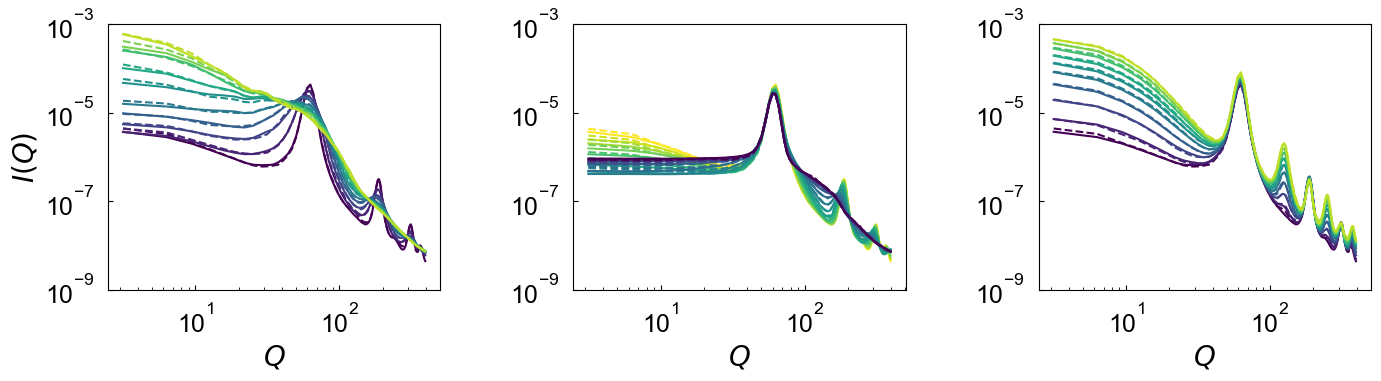

In [18]:
fig = plt.figure(figsize=(15,5))

# varying k_z
ax1 = fig.add_subplot(1,3,1)
fp_k_z_list = []
for i, k_z_i in enumerate(set_k_z):
    parameters = [k_z_i,set_kappa[0],set_alpha[0]]
    index = id_params(parameters)

    ## fitting
    IQ_GT = S_q_sm_Grid[index,]
    def loss(fp):
        lmbda = np.sum((np.log(IQ_GT)-np.log(IQ_gen_NN(fp)))**2)
        return(lmbda)

    x0 = [5, 128, 0]
    lb =  [1, 0.125, 0]
    ub =  [10, 128, 0.5]

    x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))

    opti_P = opt.minimize(loss, x0=np.array(x0), bounds = x_bounds,
                      method='L-BFGS-B',
                      jac='3-point',
                      options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
                      )
    fp_opt = opti_P.x
    fp_k_z = fp_opt.copy()
    fp_k_z_list.append(fp_k_z)

    print('GT  = [{}, {}, {}]'.format(*parameters))
    print('fit = [{}, {}, {}]'.format(*fp_k_z))

    S_q_gen_NN = (IQ_gen_NN(fp_opt))

    color = plt.cm.viridis(i/10)
    ax1.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
    ax1.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

ax1.set_xlabel(r'$Q$',fontsize=20)
ax1.set_ylabel(r'$I(Q)$',fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-9,1e-3])
ax1.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()

# varying kappa
ax2 = fig.add_subplot(1,3,2)
fp_kappa_list = []
for i, kappa_i in enumerate(set_kappa):
    parameters = [set_k_z[0],kappa_i,set_alpha[0]]
    index = id_params(parameters)

    ## fitting
    IQ_GT = S_q_sm_Grid[index,]
    def loss(fp):
        lmbda = np.sum((np.log(IQ_GT)-np.log(IQ_gen_NN(fp)))**2)
        return(lmbda)

    x0 = [1, 10, 0]
    lb =  [1, 0.125, 0]
    ub =  [10, 128, 0.5]

    x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))

    opti_P = opt.minimize(loss, x0=np.array(x0), bounds = x_bounds,
                      method='L-BFGS-B',
                      jac='3-point',
                      options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
                      )
    fp_opt = opti_P.x
    fp_kappa = fp_opt.copy()
    fp_kappa_list.append(fp_kappa)

    print('GT  = [{}, {}, {}]'.format(*parameters))
    print('fit = [{}, {}, {}]'.format(*fp_kappa))

    S_q_gen_NN = (IQ_gen_NN(fp_opt))

    color = plt.cm.viridis(np.log(kappa_i)/np.log(128)) 
    ax2.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
    ax2.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

ax2.set_xlabel(r'$Q$',fontsize=20)
# ax2.set_ylabel(r'$I(Q)$',fontsize=20)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim([1e-9,1e-3])
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# varying alpha
ax3 = fig.add_subplot(1,3,3)
fp_alpha_list = []
for i, alpha_i in enumerate(set_alpha):
    parameters = [set_k_z[0],set_kappa[0],alpha_i]
    index = id_params(parameters)

    ## fitting
    IQ_GT = S_q_sm_Grid[index,]
    def loss(fp):
        lmbda = np.sum((np.log(IQ_GT)-np.log(IQ_gen_NN(fp)))**2)
        return(lmbda)

    x0 = [1, 128, 0.25]
    lb =  [1, 0.125, 0]
    ub =  [10, 128, 0.5]

    x_bounds = opt.Bounds(lb=np.array(lb), ub=np.array(ub))

    opti_P = opt.minimize(loss, x0=np.array(x0), bounds = x_bounds,
                      method='L-BFGS-B',
                      jac='3-point',
                      options={'maxiter':1000,'ftol':1e-12, 'gtol':1e-12},
                      )
    fp_opt = opti_P.x
    fp_alpha = fp_opt.copy()
    fp_alpha_list.append(fp_alpha)

    print('GT  = [{}, {}, {}]'.format(*parameters))
    print('fit = [{}, {}, {}]'.format(*fp_alpha))

    S_q_gen_NN = (IQ_gen_NN(fp_opt))

    color = plt.cm.viridis(i/10)
    ax3.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
    ax3.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

ax3.set_xlabel(r'$Q$',fontsize=20)
# ax3.set_ylabel(r'$I(Q)$',fontsize=20)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim([1e-9,1e-3])
ax3.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout(pad=5)



In [19]:
from scipy.io import savemat
mdic = {'fp_k_z_list':fp_k_z_list, 'fp_kappa_list':fp_kappa_list, 'fp_alpha_list':fp_alpha_list}
savemat('fp_opt_grid.mat', mdic)

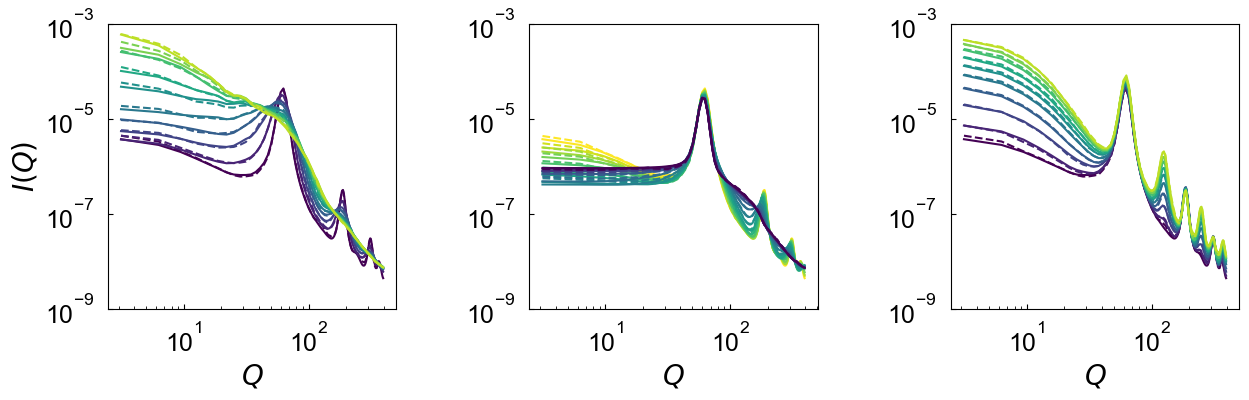

In [29]:
fig = plt.figure(figsize=(13.5,4.5))

data = loadmat('fp_opt_grid.mat')
fp_k_z_list = data['fp_k_z_list']
fp_kappa_list = data['fp_kappa_list']
fp_alpha_list = data['fp_alpha_list']

# varying k_z
ax1 = fig.add_subplot(1,3,1)
for i, k_z_i in enumerate(set_k_z):
    parameters = [k_z_i,set_kappa[0],set_alpha[0]]
    index = id_params(parameters)

    ## fitting
    fp_opt = fp_k_z_list[i]

    S_q_gen_NN = (IQ_gen_NN(fp_opt))

    color = plt.cm.viridis(i/10)
    ax1.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
    ax1.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

ax1.set_xlabel(r'$Q$',fontsize=20)
ax1.set_ylabel(r'$I(Q)$',fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-9,1e-3])
ax1.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax1.set_aspect(0.38)

plt.tight_layout()

# varying kappa
ax2 = fig.add_subplot(1,3,2)
for i, kappa_i in enumerate(set_kappa):
    parameters = [set_k_z[0],kappa_i,set_alpha[0]]
    index = id_params(parameters)

    ## fitting
    fp_opt = fp_kappa_list[i]

    S_q_gen_NN = (IQ_gen_NN(fp_opt))

    color = plt.cm.viridis(np.log(kappa_i)/np.log(128)) 
    ax2.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
    ax2.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

ax2.set_xlabel(r'$Q$',fontsize=20)
# ax2.set_ylabel(r'$I(Q)$',fontsize=20)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim([1e-9,1e-3])
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax2.set_aspect(0.38)

# varying alpha
ax3 = fig.add_subplot(1,3,3)
for i, alpha_i in enumerate(set_alpha):
    parameters = [set_k_z[0],set_kappa[0],alpha_i]
    index = id_params(parameters)

    ## fitting
    fp_opt = fp_alpha_list[i]

    S_q_gen_NN = (IQ_gen_NN(fp_opt))

    color = plt.cm.viridis(i/10)
    ax3.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)
    ax3.plot(qq[1:-1],S_q_gen_NN,'--',color=color)

ax3.set_xlabel(r'$Q$',fontsize=20)
# ax3.set_ylabel(r'$I(Q)$',fontsize=20)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim([1e-9,1e-3])
ax3.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax3.set_aspect(0.38)

plt.tight_layout(pad=2.5)

